# "Laplacian Matrix Learning for Smooth Graph Signal Representation" [Dong et al., 2015]

In [2]:
from scipy import spatial
from sklearn import metrics
import pygsp
import utils
import learn_graph as lg
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import cvxopt
import copy
%matplotlib inline

## Generate ground truth graph

In [3]:
N = 256 # Number of nodes
Ne = (N * (N - 1)) // 2 # number of edges
D = 4 # dimension of signal

# G = pygsp.graphs.Sensor(N, seed=1)
G = pygsp.graphs.TwoMoons(moontype='synthesized', N=N, seed=1, sigmag=0.5, sigmad=0.05)

W_gt = G.W.toarray()

pos = G.coords

G_nx = nx.from_numpy_matrix(W_gt)

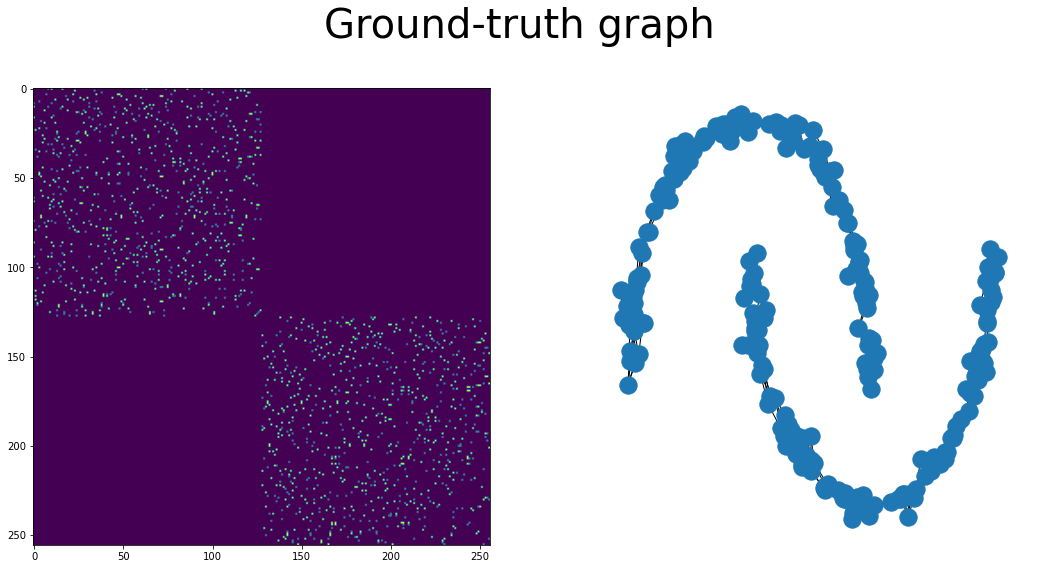

In [4]:
plt.figure(figsize=(18, 9))
plt.suptitle('Ground-truth graph', fontsize=40)

plt.subplot(1,2,1)
plt.imshow(W_gt)

plt.subplot(1,2,2)
nx.draw(G_nx, pos=pos)

## Generate samples

In [5]:
def s1(x, y): 
    return np.sin((2 - x - y)**2) 
def s2(x, y): 
    return np.cos((x + y)**2)
def s3(x, y): 
    return (x - 0.5)**2 + (y - 0.5)**3 + x - y 
def s4(x, y): 
    return np.sin(3 * ( (x - 0.5)**2 + (y - 0.5)**2 ) )

X = 5 * np.array((s1(G.coords[:,0], G.coords[:,1]), 
                  s2(G.coords[:,0], G.coords[:,1]), 
                  s3(G.coords[:,0], G.coords[:,1]), 
                  s4(G.coords[:,0], G.coords[:,1]))).T


## Generate labels

In [6]:
def labels(x, y):
    n = len(x)
    return np.array([1 if i < N // 2 else 0 for i in range(N)])

y = labels(G.coords[:, 0], G.coords[:, 1])

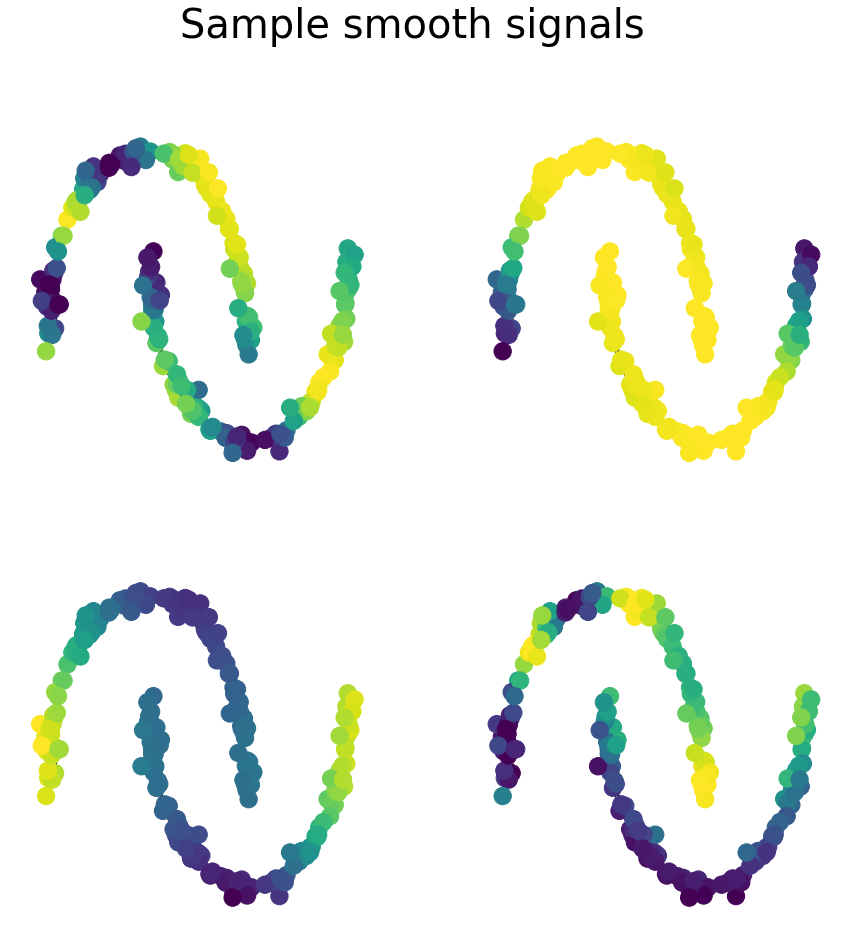

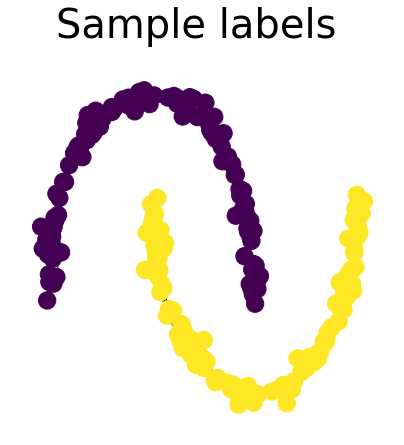

In [7]:
plt.figure(figsize=(15, 15))
plt.suptitle('Sample smooth signals', fontsize=40)

plt.subplot(2,2,1)
nx.draw(G_nx, pos=pos, node_color=X[:,0])

plt.subplot(2,2,2)
nx.draw(G_nx, pos=pos, node_color=X[:,1])

plt.subplot(2,2,3)
nx.draw(G_nx, pos=pos, node_color=X[:,2])

plt.subplot(2,2,4)
nx.draw(G_nx, pos=pos, node_color=X[:,3])

plt.figure(figsize=(7, 7))
plt.suptitle('Sample labels', fontsize=40)

plt.subplot(1, 1, 1)
nx.draw(G_nx, pos=pos, node_color=y)

In [64]:
# Sample certain points for which we know the data
fraction = 0.2 # fraction of nodes for which we know the label

from copy import deepcopy

y_known = deepcopy(y)

for i in range(N):
    if np.random.rand() > fraction:
        y_known[i] = -1
    
# print(y_known)

## Solve the optimization problem

In [65]:
known_nodes, unknown_nodes = [], []
for i in range(N):
    if y_known[i] != -1:
        known_nodes.append((i, y_known[i]))
    else:
        unknown_nodes.append(i)

# now apply this algorithm
class_0 = []
class_1 = []
for i, cl in known_nodes:
    if cl == 0:
        class_0.append(i)
    else:
        class_1.append(i)

predicted_class = deepcopy(y_known)

# print(class_0)
# print(class_1)
# print(predicted_class)

stop_after_choosing = N

r = None
iteration_number = 0

W = None

while True:
    iteration_number += 1
    # learn graph
    W, problem = lg.l2_degree_reg_known_classes(X,
                                                [class_0, class_1],
                                                forced_distance=1e5 * iteration_number,
                                                dist_type='sqeuclidean',
                                                alpha=1,
                                                s=N,
                                                retall=True)
    W[W < 0] = 0
    old_chosen = len(class_0) + len(class_1)
    chosen = len(class_0) + len(class_1)
    
    ratio_0_1 = [0 for i in range(N)]
    ratio_1_0 = [0 for i in range(N)]
    
    eps = 1e-9
    
    for i in range(N):
        if predicted_class[i] != -1: continue
        cnt_0, cnt_1 = 0, 0
        sum_0, sum_1 = 0, 0
        for j in range(N):
            if predicted_class[j] == -1: continue
            elif predicted_class[j] == 0:
                cnt_0 += 1
                sum_0 += W[i][j]
            else:
                cnt_1 += 1
                sum_1 += W[i][j]
        if cnt_0 == 0 and cnt_1 == 0:
            continue
        avg0 = sum_0 / (cnt_0 + eps)
        avg1 = sum_1 / (cnt_1 + eps)
        if avg0 > avg1:
            ratio_0_1[i] = avg0 / (eps + avg1)
        else:
            ratio_1_0[i] = avg1 / (eps + avg0)

    max_ratio_0_1 = max(ratio_0_1)
    max_ratio_1_0 = max(ratio_1_0)
    
    r = 1 + 10./(iteration_number)
    if chosen == old_chosen:
        r = min(r, max(max_ratio_0_1, max_ratio_1_0))
    
    for i in range(N):
        if predicted_class[i] != -1: continue
        if ratio_0_1[i] >= r:
            predicted_class[i] = 0
            class_0.append(i)
            chosen += 1
        elif ratio_1_0[i] >= r:
            predicted_class[i] = 1
            class_1.append(i)
            chosen += 1

    # print(max_ratio_0_1, max_ratio_1_0, iteration_number, chosen)
    if chosen >= stop_after_choosing:
        predicted_class = np.where(predicted_class != -1, predicted_class, np.random.randint(2, size=N))
        break

In [66]:
W_naive, problem_naive = lg.l2_degree_reg(X,
                                          dist_type='sqeuclidean',
                                          alpha=1,
                                          s=N,
                                          retall=True)

## Recover learned graph

In [67]:
W_thresh = np.max(W_gt) * W / np.max(W)
W_thresh[W_thresh < 0.1 * np.max(W_gt)] = 0
G_learned = nx.from_numpy_matrix(W_thresh)

W_naive_thresh = np.max(W_gt) * W_naive / np.max(W_naive)
W_naive_thresh[W_naive_thresh < 0.1 * np.max(W_gt)] = 0
G_learned_naive = nx.from_numpy_matrix(W_naive_thresh)

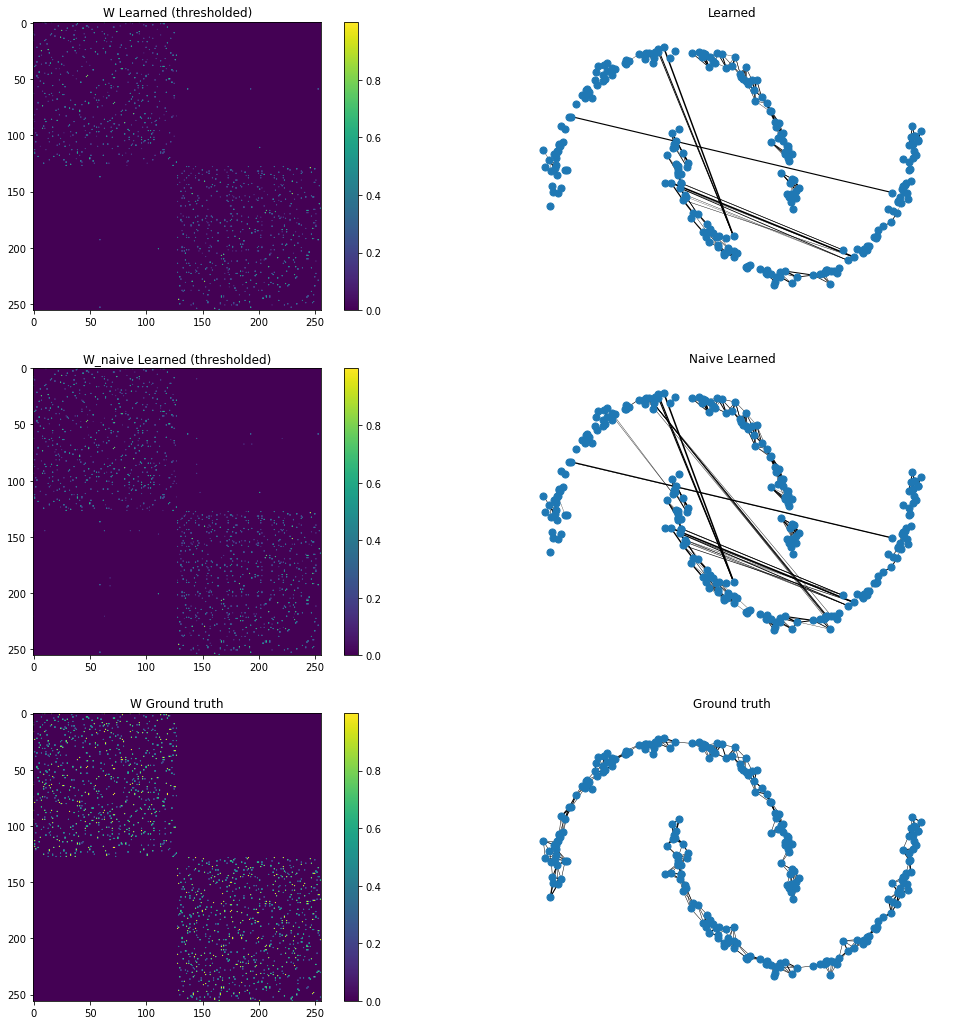

In [68]:
NODE_SIZE = 50
FACTOR = 2

plt.figure(figsize=(18, 18))
plt.subplot(3,2,1)
plt.imshow(W_thresh)
plt.colorbar()
plt.title('W Learned (thresholded)')

plt.subplot(3,2,2)
edge_wts = [FACTOR * W_thresh[edge[0], edge[1]] for edge in G_learned.edges()]
nx.draw(G_learned, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Learned')




# plt.figure(figsize=(18, 18))
plt.subplot(3,2,3)
plt.imshow(W_naive_thresh)
plt.colorbar()
plt.title('W_naive Learned (thresholded)')

plt.subplot(3,2,4)
edge_wts = [FACTOR * W_naive_thresh[edge[0], edge[1]] for edge in G_learned_naive.edges()]
nx.draw(G_learned_naive, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Naive Learned')




# plt.figure(figsize=(18, 18))
plt.subplot(3,2,5)
plt.imshow(W_gt)
plt.colorbar()
plt.title('W Ground truth')

FACTOR /= 2

plt.subplot(3,2,6)
edge_wts = [FACTOR * W_gt[edge[0], edge[1]] for edge in G_nx.edges()]
nx.draw(G_nx, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Ground truth')

plt.show()

## Label Propagation

In [69]:
def label_propagation(N, W, y_known, ITER=10000):
    assert len(W) == N
    for i in range(N):
        assert len(W[i]) == N
    assert len(y_known) == N
    assert np.sum(y_known == -1) < N
    
    originally_labelled = (y_known != -1)
    
    y_0 = np.array([float(x) for x in (y_known == 0)])
    y_1 = np.array([float(x) for x in (y_known == 1)])
    y_original = np.array([y_0, y_1]).T
    y_cur = np.array([y_0, y_1]).T
    W = deepcopy(W)
    
    for i in range(N):
        s = np.sum(W[i])
        if s != 0: W[i] /= s
    
    eps = 1e-4
    y_prv = np.ones(y_cur.shape)
    
    for iteration in range(ITER):
        if np.sum(np.abs(y_cur - y_prv)) < eps: break
        y_prv = y_cur
        y_cur = np.matmul(W, y_cur)
        s = np.sum(y_cur, axis=1).reshape(-1, 1)
        s = np.where(s != 0, s, 1)
        y_cur /= s
        y_cur = np.where(originally_labelled[:, np.newaxis], y_original, y_cur)
    
    return np.argmax(y_cur, axis=1)

In [70]:
y_pred_naive = label_propagation(N, W_naive, y_known)
y_pred       = label_propagation(N, W,       y_known)

print("accuracy using our algorithm =", metrics.accuracy_score(y, predicted_class))
print("accuracy using our algorithm and label propagation =", metrics.accuracy_score(y, y_pred))
print("accuracy using only label propagation =", metrics.accuracy_score(y, y_pred_naive))

print("f1 score using our algorithm =", metrics.f1_score(y, predicted_class))
print("f1 score using our algorithm and label propagation =", metrics.f1_score(y, y_pred))
print("f1 score using only label propagation =", metrics.f1_score(y, y_pred_naive))

accuracy using our algorithm = 0.98828125
accuracy using our algorithm and label propagation = 0.98046875
accuracy using only label propagation = 0.58984375
f1 score using our algorithm = 0.9883268482490272
f1 score using our algorithm and label propagation = 0.9803921568627452
f1 score using only label propagation = 0.3636363636363636


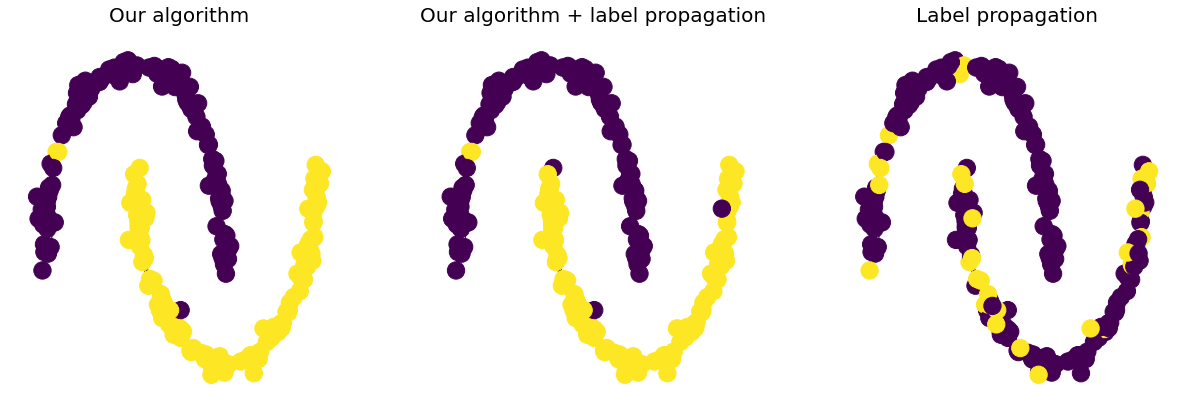

In [71]:
plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.title('Our algorithm', fontsize=20)
nx.draw(G_nx, pos=pos, node_color=predicted_class)

plt.subplot(1, 3, 2)
plt.title('Our algorithm + label propagation', fontsize=20)
nx.draw(G_nx, pos=pos, node_color=y_pred)

plt.subplot(1, 3, 3)
plt.title('Label propagation', fontsize=20)
nx.draw(G_nx, pos=pos, node_color=y_pred_naive)